In [1]:
import numpy as np
import theano
import theano.tensor as T
import os, pickle, gzip
from PIL import Image
import matplotlib.pyplot as plt

from theano import function
rng = np.random

In [2]:
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
f.close()

In [3]:
def shared_dataset(data_xy):
    data_x, data_y = data_xy
    shared_x = theano.shared(np.asarray(data_x, dtype=theano.config.floatX))
    shared_y = theano.shared(np.asarray(data_y, dtype=theano.config.floatX))

    return shared_x, T.cast(shared_y, 'int32')

test_set_x, test_set_y = shared_dataset(test_set)
valid_set_x, valid_set_y = shared_dataset(valid_set)
train_set_x, train_set_y = shared_dataset(train_set)

batch_size = 500

data = train_set_x[2 * batch_size: 3 * batch_size]
label = train_set_y[2 * batch_size: 3 * batch_size]

In [4]:
class SimpleTwoLayer(object):
    
    n_in = 2
    n_hidden = 240
        
    a = theano.shared(
        value=np.random.choice(
            [-1, 1],
            (n_hidden,),
        ).astype(theano.config.floatX),
        name='a',
        borrow=True
    )

    def __init__(self, input):

        self.W = theano.shared(
            value=np.random.randn(
                self.n_in, self.n_hidden
            ).astype(theano.config.floatX),
            name='W',
            borrow=True
        )

        self.y_pred = T.dot(T.nnet.relu(T.dot(input, self.W)), self.a) / np.sqrt(self.n_hidden)
        self.params = [self.W, self.a]
        self.input = input
        
    def cost(self, y):
        return T.sum((self.y_pred - y)**2)

def a_func(x, y):
    return x + y

def train(sample_x, sample_y, learning_rate=0.0001, n_epoches=100):
    batch_size = 500
    n_train_batches = sample_x.get_value().shape[0] // batch_size

    index = T.lscalar()
    
    x = T.matrix('x')
    y = T.vector('y')
    model = SimpleTwoLayer(input=x)
    cost = model.cost(y)
    g_W = T.grad(cost=cost, wrt=model.W)
    updates = [(model.W, model.W - g_W * learning_rate)]
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: sample_x[index * batch_size: (index + 1) * batch_size],
            y: sample_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    epoch = 0
    while epoch < n_epoches:
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
            minibatch_avg_cost = train_model(minibatch_index)
            iter = (epoch - 1) * n_train_batches + minibatch_index
    return model

In [5]:
def avg_model(models):
    x = T.matrix('x')
    shape = models[0].W.get_value().shape
    avg_model = SimpleTwoLayer(input=x,)
    Ws = np.zeros((len(models), shape[0], shape[1]))
    for i in range(len(models)):
        Ws[i] = models[i].W.get_value()
    avg_model.W.set_value(np.mean(Ws, axis=0))
    return avg_model

In [6]:
def generate_sample(N):
    x = np.random.randn(N,2)
    y = np.zeros((N,))
    for i in range(N):
        y[i] = a_func(x[i,0], x[i,1])
    return x, y

In [7]:
x, y = generate_sample(2000)
models = []
n_model = 200
for i in range(n_model):
    models.append(train(theano.shared(x.astype(np.float64)), theano.shared(y.astype(np.float64))))

In [8]:
def predict(model, test_x):
    predict_model = theano.function(
        inputs=[model.input],
        outputs=model.y_pred
    )

    predicted_values = predict_model(test_x)
    return predicted_values


In [9]:
test_x, test_y = generate_sample(1000)

predicted_y = predict(models[0], test_x)
model = avg_model(models)
avg_predicted_y = predict(model, test_x)
errors = np.zeros((len(models), len(test_x)))
for i in range(len(models)):
    model = avg_model(models[:i+1])
    avg_predicted_y = predict(model, test_x)
    errors[i] = avg_predicted_y - test_y

In [10]:
x = T.matrix('x')
shape = models[0].W.get_value().shape
avg_model = SimpleTwoLayer(input=x,)
Ws = np.zeros((len(models), shape[0], shape[1]))
for i in range(len(models)):
    Ws[i] = models[i].W.get_value()

In [11]:
Corr = np.corrcoef(errors.T)

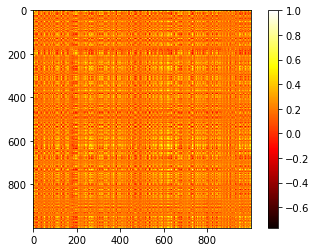

In [12]:
plt.imshow(Corr, cmap='hot')
plt.colorbar() 
plt.show()

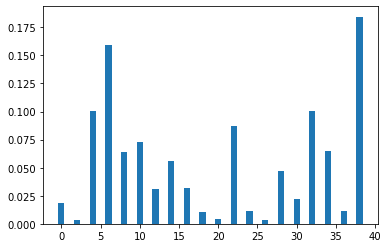

In [13]:
plt.bar(np.arange(20)*2,np.abs(np.mean(errors, axis=0)[:20]))
plt.show()

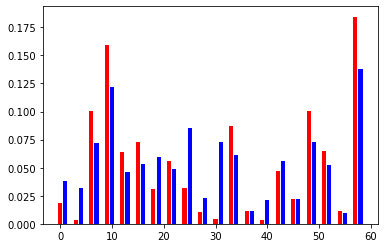

In [14]:
n_sample = 20
bias = np.abs(np.mean(errors, axis=0)[:n_sample])
std = np.std(errors, axis=0)[:n_sample]

x_val = []
y_val = []
col_val = []

for i in range(n_sample):
    x_val.append(i*3)
    x_val.append(i*3+1)
    y_val.append(bias[i])
    y_val.append(std[i])
    col_val.append('r')
    col_val.append('b')
    
plt.bar(x_val, y_val, color=col_val)
plt.show()

In [27]:
def show_digit(image):
    img = Image.fromarray(np.uint8(image), 'L')
    img.show()